In [87]:
import pickle
from ggplot import *
import pandas as pd
import datetime
import sys
import numpy as np
sys.path.append('../../dissdat/database/')
from db import make_session


In [254]:
def timeline(selection, df, daily_counts):
    selected_times = pd.DataFrame(df['created_at'].loc[selection])
    selected_per_day = (selected_times
                        .groupby(selected_times.created_at.dt.dayofyear)
                        .count())
    selected_per_day['count'] = selected_per_day['created_at']
    selected_per_day['date'] = selected_per_day.index.astype(int)
    selected_per_day['date'] = pd.DatetimeIndex(
            [datetime.datetime(2015, 1, 1) 
             + datetime.timedelta(days=int(x-1)) for
             x in selected_per_day['date']])
    every_day = pd.DataFrame({'date': pd.date_range(start='1-1-2015', 
                                                    end='12-31-2015')})
    tl = (every_day.merge(selected_per_day[['count', 'date']], how='left')
                   .fillna(0))
    tl['proportion'] = tl['count'] / daily_counts['count']
    return tl[['proportion', 'date']]

def get_index(x, element):
    try:
        return x.index(element)
    except ValueError:
        return None
    
def query_dtm(query, dtm, terms):
    '''
    Query the doc-term matrix for documents containing at leas on term of query
    '''
    query_idx = [get_index(terms, w) for w in query if get_index(terms, w) is not None]
    return np.squeeze(np.asarray(dtm[:, query_idx].sum(axis=1) != 0))

In [250]:
dtm_full = pickle.load(open('../data/dtms/dtm_non_normalized_full.p', 'rb'))
terms = pickle.load(open('../data/dtms/full_terms.p', 'rb'))
df_full = pickle.load(open('../data/dtms/df_full.p', 'rb'))

In [251]:
kwords = pickle.load(open('../data/dtms/kwords.p', 'rb'))

In [252]:
daily_counts = df_full.groupby(df_full.created_at.dt.dayofyear).count()
daily_counts['count'] = daily_counts['created_at']
daily_counts['date'] = daily_counts.index.astype(int)
daily_counts['date'] = pd.DatetimeIndex([datetime.datetime(2015, 1, 1) 
                                         + datetime.timedelta(days=int(x-1)) for
                                         x in daily_counts['date']])
daily_counts.index = range(0,365)

In [317]:
kwords.sort_values('weight', inplace=True, ascending=False)

In [318]:
words = kwords.iloc[:100]

In [364]:
proportion = []
date = []
iteration = []
keywords = []
N_ITERATIONS = 500
N_WORDS = 5
np.random.seed(55771)
for i in range(0, N_ITERATIONS):
    query = list(words.sample(N_WORDS, weights=words['weight']).word)
    #query = list(kwords.sample(N_WORDS).word)
    keywords.append(query)
    selection = df_full[query_dtm(query, dtm_full, terms)].index
    tl = timeline(selection, df_full, daily_counts)
    proportion.extend(list(tl.proportion))
    date.extend(list(tl.date))

In [365]:
iteration = [i for i in range(N_ITERATIONS) for _ in range(365)]

In [438]:
pdat = pd.DataFrame({'proportion': proportion, 'iteration': iteration, 
                     'date': date})

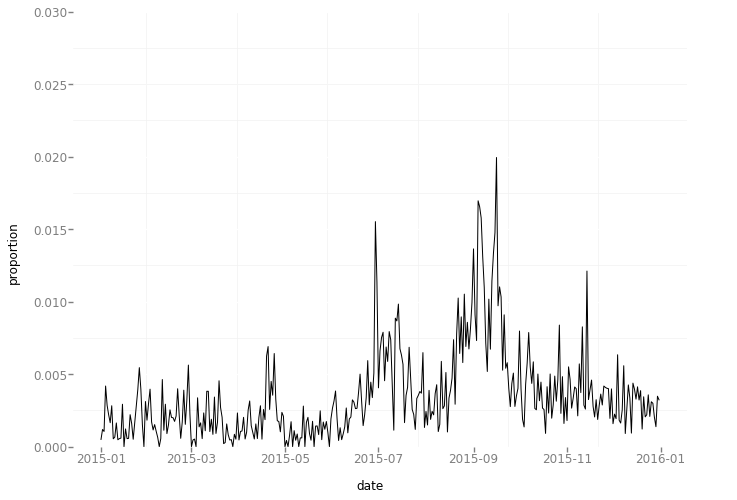

<ggplot: (8734646571286)>


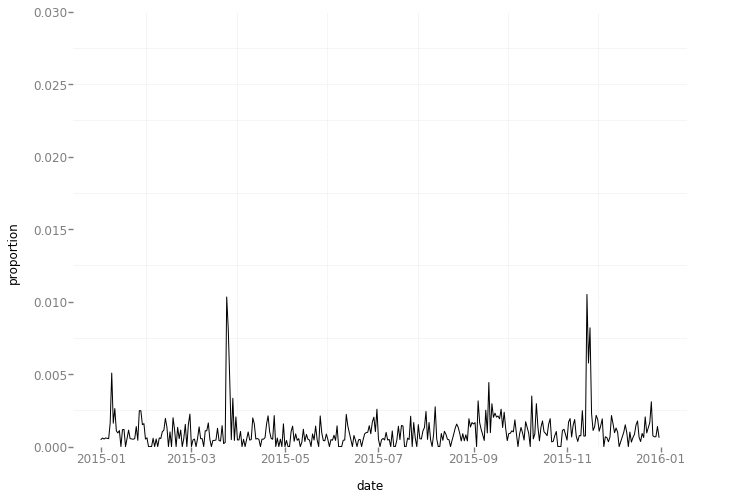

<ggplot: (8734782825329)>


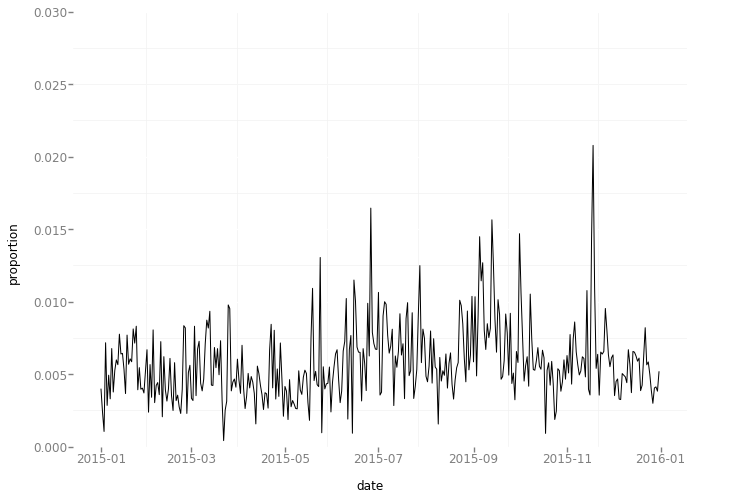

<ggplot: (-9223363302208267783)>


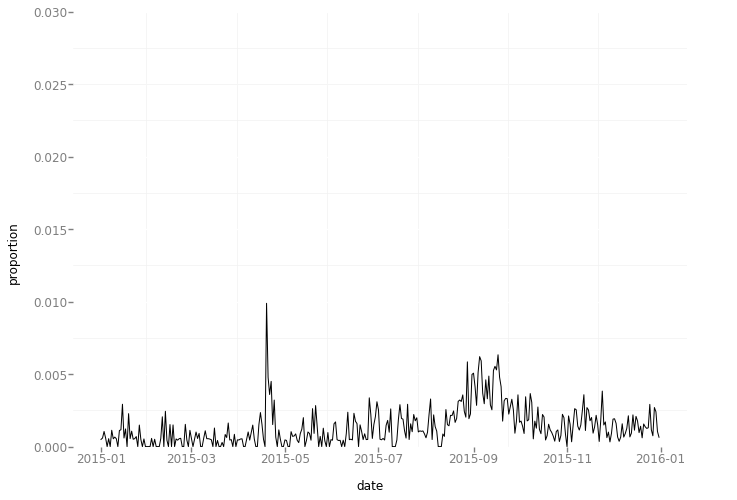

<ggplot: (-9223363302208298906)>


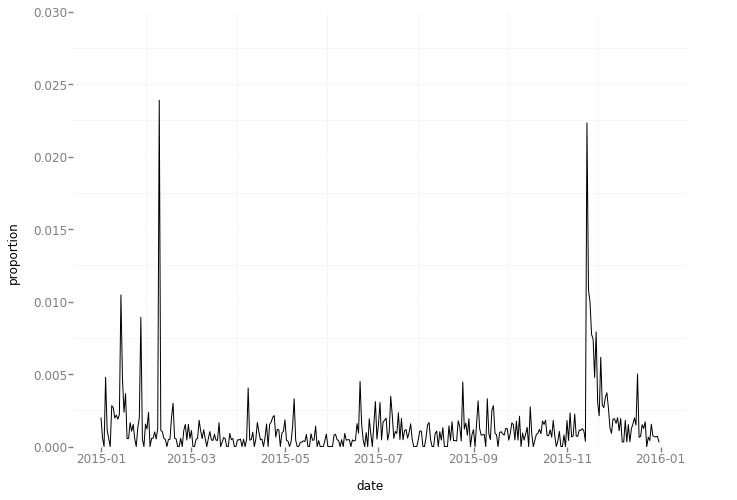

<ggplot: (-9223363302208225606)>


In [456]:
for i in [146, 382, 254, 469, 103]:
    p = ggplot(pdat[pdat['iteration'].isin([i])], aes(x = 'date', y = 'proportion')) \
        + geom_line() \
        + theme_bw() \
        + ylim(0,0.03)
    print(p)
    #p.save(f'../presentation/figures/intro_timeline_{i}.png', width=12, height=6, dpi=300)

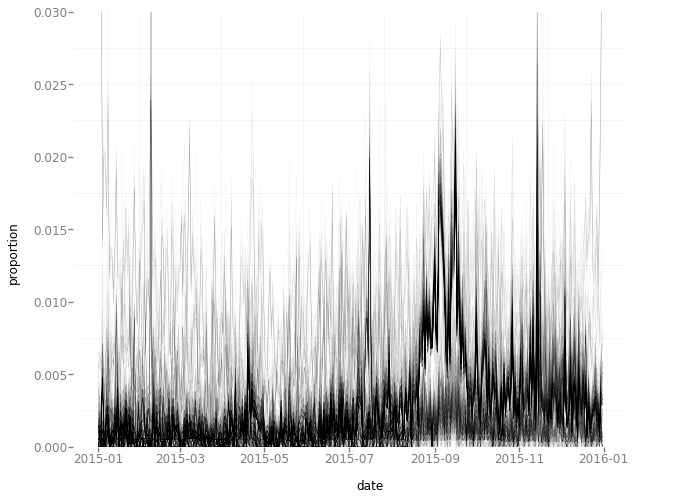

<ggplot: (-9223363302102521989)>


In [455]:
p = ggplot(pdat, aes(x = 'date', y = 'proportion', group='iteration')) \
        + geom_line(alpha=0.1, size=0.2) \
        + theme_bw() \
        + ylim(0,0.03)
print(p)
#p.save('../presentation/figures/intro_timeline_all.png', width=12, height=6, dpi=300)

In [451]:
for i in [146, 382, 254, 469, 103]:
    print(keywords[i])

['griechenland', 'asylpolitik', 'flüchtlinge', 'flucht', 'ausländer']
['asylanten', 'asylverfahren', 'opfer', 'flucht', 'immigration']
['asylpolitik', 'flüchtling', 'zuflucht', 'deutschland', 'asyl']
['asyl', 'asylbewerber', 'flüchtlingen', 'flucht', 'mittelmeer']
['asylgesetz', 'terror', 'krise', 'migration', 'flüchtlingspolitik']
